

# Testing conformity characteristic
    
State-of-the-art says that conformal learning gives conformity guarantees, that is we can bound the error rate with a predifined value. In this notebook we test this property of conformal prediction and also check if the same properties can be achieved in a different way.
    
We follow experimental setup from 'Model-Agnostic Nonconformity Functions for Conformal Classification' (check `papers` folder in repository):
1. 10-fold cross validation (90\\% - training data, 10\\% - test data)
2. Training data is split into proper training and calibration set in the following proportion: 4:1 (80\\% - proper training, 20\\% calibration)
3. It means we have:
    1. 72\\% - proper training
    2. 18\\% - calibrations
    3. 10\\% - testing
        
**TODO:**
1. Run conformal classification with SVM for 3 datasets `breast cancer`, `iris`, `wine` with $\epsilon \in \{0.01, 0.05, 0.1, 0.2\}$ and check what will be the error rate. This is similar to results in Tab. V from the paper (a value for every dataset: mean + std)
2. Check if we can get similar results in a different way


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
from nonconformist.nc import InverseProbabilityErrFunc
from nonconformist.nc import MarginErrFunc

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [82]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Functions definition

## Analysis

In [83]:
def get_fold(fold, idx, test_len, cal_len):
    idx = np.array(idx)
    start_idx = (fold-1) * test_len
    end_idx = min(fold * test_len, len(idx))
    idx_test = idx[start_idx:end_idx]
    idx_train = idx[0:start_idx].tolist()
    idx_train.extend(idx[end_idx:].tolist())
    # todo the code will not compile, as idx_all_train is unknown
    # in idx_train you have proper training and calibration sets, you now have to split them into 2 separate sets
    # we agreed to do it like this
    # take first cal_len elements from idx_all_train as calibration and the rest as proper train set
    idx_cal = idx_train[0:cal_len]
    idx_train = idx_train[cal_len:]
    return np.array(idx_train), np.array(idx_test), np.array(idx_cal)


# get size of training, calibration and testing sets
def get_train_cal_test_len(N, test_frac=0.1, cal_frac=0.2):
    # N - size of the dataset
    # test_frac - fraction of test data from the whole dataset, we'll use test_frac=0.1
    # test_frac depends on the number of folds, test_frac=1/num_folds
    # whole dataset = test_data + all_training_data
    # cal_frac - fraction of calibration data from the all_training_data, we'll use cal_frac=0.2
    # all_training_data = calibration_data + training_data
    test_len = round(N * test_frac)
    all_train_len = N - test_len
    cal_len = round(all_train_len * cal_frac)
    train_len = all_train_len - cal_len
    return(train_len, cal_len, test_len)


# calculating metrics: oneC & avgC
def get_oneC_avgC(prediction):
    arr = np.array(prediction)
    oneC = 0
    avgC = 0
    for i in range(0, len(arr)):
        num_predicted = arr[i].sum()
        avgC += num_predicted
        if num_predicted == 1:
            oneC += 1
        pass
    oneC /= len(arr)
    avgC /= len(arr)
    return (oneC,avgC)


# calculating metrics: error_rate
def get_accuracy(prediction, real_class):
    correct = 0
    N = len(prediction)
    for i in range(0, N):
        if (real_class[i] < len(prediction[i])) and (prediction[i][real_class[i]]):
            correct += 1
        pass
    return correct / N


def filter_class_res(prediction, epsilon):
    result = []
    for line in prediction:
        tmp = copy.deepcopy(line)
        removed = 0
        # removed_idx = []

        to_continue = True
        while to_continue:
            min_idx = np.argmin(tmp)
            if tmp[min_idx] + removed <= epsilon:
                removed += tmp[min_idx]
                # removed_idx.append(min_idx)
                tmp[min_idx] = 2.
            else:
                to_continue = False
                pass
            pass
        # now set remove all values set to 2.
        result.append(tmp < 2)
        # print(line)
        pass
    return np.array(result)


def filter_class_res_total(prediction, epsilon):
    tmp = copy.deepcopy(prediction).flatten()
    tot_epsilon = epsilon * len(prediction)
    removed = 0
    to_continue = True
    while to_continue:
        min_idx = np.argmin(tmp)
        if tmp[min_idx] + removed < tot_epsilon:
            removed += tmp[min_idx]
            tmp[min_idx] = 2.
            pass
        else:
            to_continue = False
            pass
        pass
    result = tmp < 2.
    result = result.reshape(prediction.shape)
    return result

## Function for plotting

In [84]:
def autolabel(rects):
    #Attach a text label above each bar in *rects*, displaying its height.
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Data loading

In [85]:
def load_wine_red():
    print('Loading wine_red')
    # load red wine dataset
    file = '../datasets/winequality-red.csv'
    df = pd.read_csv(file, sep=';')
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    target = df[df.columns[-1]].values
    target -= min(target)
    data = {'target': df[df.columns[-1]].values, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data


In [86]:
def load_wine_white():
    print('Loading wine_white')
    # load red wine dataset
    file = '../datasets/winequality-white.csv'
    df = pd.read_csv(file, sep=';')
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    target = df[df.columns[-1]].values
    target -= min(target)
    data = {'target': df[df.columns[-1]].values, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data

### This is the main function, runs conformal prediction

In [87]:
def run_conformal(data, epsilon_arr, model_obj=SVC, params={'probability': True},
                  err_func=MarginErrFunc, smoothing=True, seed=1, verbose=True):
    np.random.seed(seed=seed)
    
    data_size = len(data['target'])
    idx = np.random.permutation(data_size)
    train_len, cal_len, test_len = get_train_cal_test_len(data_size, 0.1, 0.2)

    if verbose:
        print('Info about dataset: ')
        print('classes: {}'.format(list(data['target_names'])))
        print('size of the dataset: {}'.format(len(data['target'])))
        print('train = {}, cal = {}, test = {}'.format(train_len, cal_len, test_len))
        pass
    
    # define arrays to store information in
    res_epsilon_arr = []
    fold_arr = []
    # error rate for normal SVM
    error_rate_trad_arr = []
    # info for conformal learning 
    oneC_arr = []
    avgC_arr = []
    error_rate_arr = []
    # info for simulation of conformal learning (exclude labels until you get 1-eps total probability)
    oneC_svm_arr = []
    avgC_svm_arr = []
    error_rate_svm_arr = []
    
    for fold in range(1, num_folds + 1):
        idx_train, idx_test, idx_cal = get_fold(fold, idx, test_len, cal_len)
        # first run normal SVM
        # put train and calibration together
        idx_all_train = np.concatenate((idx_train, idx_cal))
        clf = model_obj(**params)
        clf.fit(data['data'][idx_all_train, :], data['target'][idx_all_train])
        prediction = clf.predict(data['data'][idx_test, :])
        error_rate_svm = (data['target'][idx_test] != prediction).sum() / len(prediction)
        
        # now for different values of eps do conformal prediction

        # build conformal model
        model = model_obj(**params)  # Create the underlying model
        nc = NcFactory.create_nc(model, err_func=err_func())  # specify non-conformity function
        icp = IcpClassifier(nc, smoothing=smoothing)
        # Fit the ICP using the proper training set
        icp.fit(data['data'][idx_train, :], data['target'][idx_train])
        # Calibrate the ICP using the calibration set
        icp.calibrate(data['data'][idx_cal, :], data['target'][idx_cal])

        for i in range(0, len(epsilon_arr)):
            epsilon = epsilon_arr[i]
            # save current info to arrays
            fold_arr.append(fold)
            res_epsilon_arr.append(epsilon)
            # save info about traditional SVM error rate
            error_rate_trad_arr.append(error_rate_svm)
            # run adjusted conformal prediction: (exclude labels until you get 1-eps total probability)
            # see function filter_class_res
            prediction_svm_prob = clf.predict_proba(data['data'][idx_test, :])
            prediction_svm = filter_class_res(prediction_svm_prob, epsilon)
            oneC, avgC = get_oneC_avgC(prediction_svm)
            real_class = data['target'][idx_test]
            accuracy = get_accuracy(prediction_svm, real_class)
            error_rate = 1 - accuracy
            oneC_svm_arr.append(oneC)
            avgC_svm_arr.append(avgC)
            error_rate_svm_arr.append(error_rate)
            # run conformal prediction itself
            # Produce predictions for the test set
            prediction = icp.predict(data['data'][idx_test, :], significance=epsilon)
            oneC, avgC = get_oneC_avgC(prediction)
            accuracy = get_accuracy(prediction, real_class)
            error_rate = 1 - accuracy
            oneC_arr.append(oneC)
            avgC_arr.append(avgC)
            error_rate_arr.append(error_rate)
            pass
        pass
    
    df_res = pd.DataFrame({})
    # save data into a data frame
    df_res['eps'] = res_epsilon_arr
    df_res['fold'] = fold_arr
    df_res['origin_err'] = error_rate_trad_arr
    # info for conformal learning 
    df_res['Conf_err'] = error_rate_arr
    df_res['Conf_oneC'] = oneC_arr
    df_res['Conf_avgC'] = avgC_arr
    # info for simulation of conformal learning
    df_res['Simul_err'] = error_rate_svm_arr
    df_res['Simul_oneC'] = oneC_svm_arr
    df_res['Simul_avgC'] = avgC_svm_arr
    # reorder
    df_res.sort_values(by=['eps', 'fold'], inplace=True)
    #df_res.reset_index(inplace=True)
    
    return df_res


## Setting random seed to get reproducible results & some constants

In [88]:
np.random.seed(seed=1)

In [89]:
num_folds = 10

In [90]:
eps_err = [0.01, 0.03, 0.05, 0.1, 0.2]

#### Input for SVM

In [91]:
svm_model_obj=SVC
svm_params={'probability': True}

#### Input for Decision trees

In [92]:
dt_model_obj=DecisionTreeClassifier
dt_min_sample_ratio = 0.05 * 0.9 * 0.8  # (5% of the effective learning set)
dt_params={}
MIN_SAMPLES_KEY = 'min_samples_split'

### Testing classifiers, which parameters are required to get probability estimates?

<font color='red'>Datasets formatting</font>

In [93]:
data = load_iris()

#### SVM

In [94]:
model = SVC(probability=True)
model.fit(data['data'], data['target'])
model.predict_proba(data['data'][140:])

array([[0.0070413 , 0.00273021, 0.99022848],
       [0.00987415, 0.03604465, 0.95408121],
       [0.00882255, 0.0917554 , 0.89942205],
       [0.00694604, 0.00145171, 0.99160225],
       [0.00725612, 0.00172666, 0.99101722],
       [0.00846971, 0.0197933 , 0.97173698],
       [0.00901939, 0.13404564, 0.85693497],
       [0.0090942 , 0.05658314, 0.93432266],
       [0.00796568, 0.01050554, 0.98152878],
       [0.00931424, 0.16558834, 0.82509742]])

In [95]:
model = SVC(probability=True)
model.fit(data['data'], data['target'])
model.predict_proba(data['data'][140:])

array([[0.00699685, 0.00221076, 0.99079238],
       [0.00978931, 0.03241233, 0.95779836],
       [0.00879214, 0.08622366, 0.9049842 ],
       [0.00689967, 0.00116797, 0.99193236],
       [0.00720813, 0.00139159, 0.99140027],
       [0.00842051, 0.01730797, 0.97427152],
       [0.00898234, 0.1283627 , 0.86265497],
       [0.00895392, 0.05197955, 0.93906653],
       [0.0079211 , 0.00893056, 0.98314834],
       [0.00926072, 0.16025366, 0.83048562]])

#### Decision tree

In [96]:
model = DecisionTreeClassifier()#(probability=True)
model.fit(data['data'], data['target'])
model.predict_proba(data['data'][140:])

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [97]:
model = DecisionTreeClassifier(min_samples_split=50)
model.fit(data['data'], data['target'])
model.predict_proba(data['data'][60:70])

array([[0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333],
       [0.        , 0.97916667, 0.02083333]])

# Analysis

## Wines both red and white

In [98]:
wine_R_df = pd.read_csv('../datasets/winequality-red.csv', sep=';')
print(len(wine_R_df))
wine_R_df.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [99]:
wine_W_df = pd.read_csv('../datasets/winequality-white.csv', sep=';')
print(len(wine_W_df))
wine_W_df.head()

4898


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [100]:
count_R_df = wine_R_df.groupby('quality').count()[['fixed acidity']]
count_R_df.columns = ['count']
count_W_df = wine_W_df.groupby('quality').count()[['fixed acidity']]
count_W_df.columns = ['count']

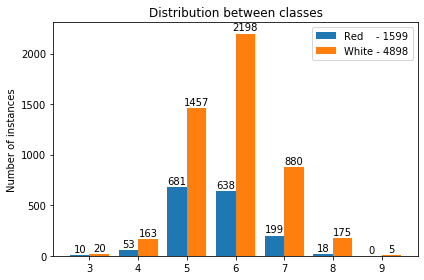

In [101]:
labels =sorted(wine_W_df['quality'].unique())
red_c = count_R_df['count'].values.tolist()
red_c.append(0)
#red_c
white_c = count_W_df['count'].values.tolist()

#men_means = [20, 34, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, red_c, width,   label='Red    - 1599')
rects2 = ax.bar(x + width/2, white_c, width, label='White - 4898')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of instances')
ax.set_title('Distribution between classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### Run conformal prediction for red wine

In [102]:
data = load_wine_red()

Loading wine_red


#### SVM

##### MarginErrFunc

In [103]:
res_df = run_conformal(data, model_obj=svm_model_obj, 
                       params=svm_params,
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
svm_mean_df = res_df.groupby('eps').mean()
svm_mean_df

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8]
size of the dataset: 1599
train = 1151, cal = 288, test = 160

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.490939,0.011887,0.011875,4.988801,0.004375,0.0,5.220770
0.03,5.5,0.490939,0.040035,0.067531,4.032303,0.011254,0.0,4.209473
0.05,5.5,0.490939,0.060668,0.104422,3.435122,0.021895,0.0,3.736745
0.10,5.5,0.490939,0.088805,0.153223,2.525369,0.051285,0.0,2.820531
0.20,5.5,0.490939,0.177614,0.287028,1.828086,0.072543,0.0,2.325228


#####  InverseProbabilityErrFunc

In [104]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8]
size of the dataset: 1599
train = 1151, cal = 288, test = 160
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.490939,0.015641,0.000000,4.057520,0.004375,0.0,5.220770
0.03,5.5,0.490939,0.030649,0.000000,3.530947,0.011254,0.0,4.209473
0.05,5.5,0.490939,0.048156,0.000000,3.030708,0.021895,0.0,3.736745
0.10,5.5,0.490939,0.095688,0.006250,2.171380,0.051285,0.0,2.820531
0.20,5.5,0.490939,0.198263,0.303329,1.699796,0.072543,0.0,2.325228


In [105]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.490939,0.011887,0.011875,4.988801,0.004375,0.0,5.220770,0.015641,0.000000,4.057520
0.03,5.5,0.490939,0.040035,0.067531,4.032303,0.011254,0.0,4.209473,0.030649,0.000000,3.530947
0.05,5.5,0.490939,0.060668,0.104422,3.435122,0.021895,0.0,3.736745,0.048156,0.000000,3.030708
0.10,5.5,0.490939,0.088805,0.153223,2.525369,0.051285,0.0,2.820531,0.095688,0.006250,2.171380
0.20,5.5,0.490939,0.177614,0.287028,1.828086,0.072543,0.0,2.325228,0.198263,0.303329,1.699796


#### Decision trees

##### MarginErrFunc

In [106]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8]
size of the dataset: 1599
train = 1151, cal = 288, test = 160

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.4259,0.006875,0.029379,5.639061,0.049406,0.069383,3.318404
0.03,5.5,0.4259,0.029383,0.093809,5.265755,0.060035,0.083133,2.951969
0.05,5.5,0.4259,0.052528,0.165739,4.683931,0.071914,0.103168,2.661085
0.10,5.5,0.4259,0.102567,0.272040,3.801494,0.112551,0.197626,2.214579
0.20,5.5,0.4259,0.199501,0.474693,2.035719,0.176376,0.331454,1.762932


#####  InverseProbabilityErrFunc

In [107]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8]
size of the dataset: 1599
train = 1151, cal = 288, test = 160

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.4259,0.012504,0.000000,5.424045,0.049406,0.069383,3.318404
0.03,5.5,0.4259,0.029399,0.003750,4.242732,0.060035,0.083133,2.951969
0.05,5.5,0.4259,0.048785,0.051262,3.298318,0.071914,0.103168,2.661085
0.10,5.5,0.4259,0.099430,0.121333,2.345888,0.112551,0.197626,2.214579
0.20,5.5,0.4259,0.203235,0.391509,1.654159,0.176376,0.331454,1.762932


In [108]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.4259,0.006875,0.029379,5.639061,0.049406,0.069383,3.318404,0.012504,0.000000,5.424045
0.03,5.5,0.4259,0.029383,0.093809,5.265755,0.060035,0.083133,2.951969,0.029399,0.003750,4.242732
0.05,5.5,0.4259,0.052528,0.165739,4.683931,0.071914,0.103168,2.661085,0.048785,0.051262,3.298318
0.10,5.5,0.4259,0.102567,0.272040,3.801494,0.112551,0.197626,2.214579,0.099430,0.121333,2.345888
0.20,5.5,0.4259,0.199501,0.474693,2.035719,0.176376,0.331454,1.762932,0.203235,0.391509,1.654159


## Plot results: error rate

Text(0.5, 1.0, 'Error rate')

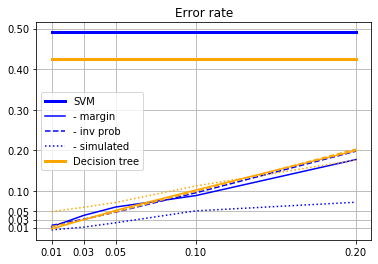

In [109]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

## Plot: oneC

Text(0.5, 1.0, 'oneC')

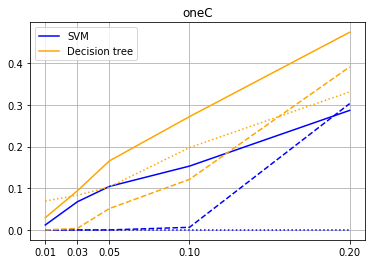

In [110]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

## Plot: avgC

Text(0.5, 1.0, 'avgC')

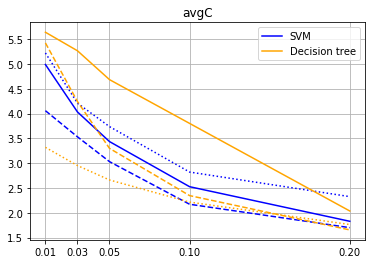

In [111]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

<font color='red'>Results: Which non-conformity function is better for which metric (oneC should be hight, avgC shold be low)</font>

|                 | avgC      | oneC      |
|---              |---        |---        |
| SVM             | inv_prob  | margin    |
| Decision trees  | inv_prob  | margin    |


### Run conformal prediction for white wine

In [112]:
data = load_wine_white()

Loading wine_white


### svm

##### MarginErrFunc

In [113]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True,
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8, 9]
size of the dataset: 4898
train = 3526, cal = 882, test = 490

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.551854,0.016944,0.001634,5.183080,0.004083,0.0,5.235991
0.03,5.5,0.551854,0.036747,0.002655,4.482324,0.007554,0.0,4.546946
0.05,5.5,0.551854,0.056142,0.006330,3.651455,0.015720,0.0,4.026546
0.10,5.5,0.551854,0.108814,0.030019,2.595313,0.050834,0.0,3.189867
0.20,5.5,0.551854,0.207631,0.186196,1.927514,0.097382,0.0,2.622477


#####  InverseProbabilityErrFunc

In [114]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8, 9]
size of the dataset: 4898
train = 3526, cal = 882, test = 490
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.551854,0.012046,0.000000,4.241907,0.004083,0.0,5.235991
0.03,5.5,0.551854,0.035317,0.000000,3.427342,0.007554,0.0,4.546946
0.05,5.5,0.551854,0.055527,0.000204,3.171721,0.015720,0.0,4.026546
0.10,5.5,0.551854,0.106362,0.001634,2.514480,0.050834,0.0,3.189867
0.20,5.5,0.551854,0.208652,0.160677,1.846261,0.097382,0.0,2.622477


In [115]:
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.551854,0.016944,0.001634,5.183080,0.004083,0.0,5.235991,0.012046,0.000000,4.241907
0.03,5.5,0.551854,0.036747,0.002655,4.482324,0.007554,0.0,4.546946,0.035317,0.000000,3.427342
0.05,5.5,0.551854,0.056142,0.006330,3.651455,0.015720,0.0,4.026546,0.055527,0.000204,3.171721
0.10,5.5,0.551854,0.108814,0.030019,2.595313,0.050834,0.0,3.189867,0.106362,0.001634,2.514480
0.20,5.5,0.551854,0.207631,0.186196,1.927514,0.097382,0.0,2.622477,0.208652,0.160677,1.846261


<font color='red'>Inv_prob - avgC, margin - oneC</font>

### decision tree

##### MarginErrFunc

In [116]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8, 9]
size of the dataset: 4898
train = 3526, cal = 882, test = 490

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.476514,0.011636,0.015927,5.697164,0.013883,0.004905,4.234764
0.03,5.5,0.476514,0.032457,0.055738,5.201855,0.026131,0.004905,3.530838
0.05,5.5,0.476514,0.054096,0.104109,4.964633,0.038588,0.005109,3.177626
0.10,5.5,0.476514,0.110648,0.183730,3.674517,0.070848,0.007559,2.679031
0.20,5.5,0.476514,0.198653,0.300540,2.105469,0.148425,0.068189,2.111868


#####  InverseProbabilityErrFunc

In [117]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [3, 4, 5, 6, 7, 8, 9]
size of the dataset: 4898
train = 3526, cal = 882, test = 490

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.476514,0.015311,0.002857,4.797573,0.013883,0.004905,4.234764
0.03,5.5,0.476514,0.035114,0.006327,3.384042,0.026131,0.004905,3.530838
0.05,5.5,0.476514,0.058594,0.011020,2.946053,0.038588,0.005109,3.177626
0.10,5.5,0.476514,0.107185,0.030826,2.436293,0.070848,0.007559,2.679031
0.20,5.5,0.476514,0.197832,0.187216,1.875495,0.148425,0.068189,2.111868


In [118]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.476514,0.011636,0.015927,5.697164,0.013883,0.004905,4.234764,0.015311,0.002857,4.797573
0.03,5.5,0.476514,0.032457,0.055738,5.201855,0.026131,0.004905,3.530838,0.035114,0.006327,3.384042
0.05,5.5,0.476514,0.054096,0.104109,4.964633,0.038588,0.005109,3.177626,0.058594,0.011020,2.946053
0.10,5.5,0.476514,0.110648,0.183730,3.674517,0.070848,0.007559,2.679031,0.107185,0.030826,2.436293
0.20,5.5,0.476514,0.198653,0.300540,2.105469,0.148425,0.068189,2.111868,0.197832,0.187216,1.875495


### Plot results: error rate

Text(0.5, 1.0, 'Error rate')

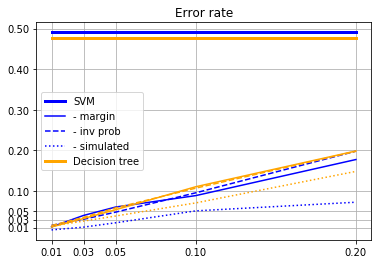

In [119]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

Text(0.5, 1.0, 'oneC')

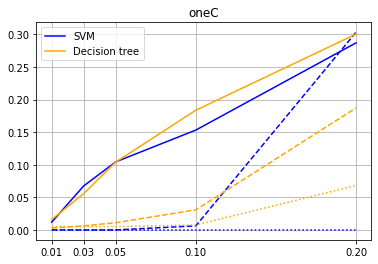

In [120]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

Text(0.5, 1.0, 'avgC')

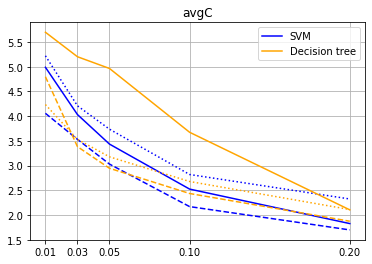

In [121]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## Breast cancer

In [122]:
data = load_breast_cancer();
data_df = pd.DataFrame(data['data'])
data_df.columns = data['feature_names']
data_df['target'] = data['target']
print(len(data_df))
data_df.head()

569


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


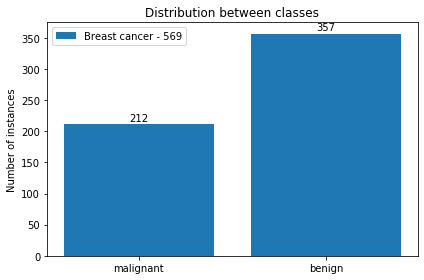

In [123]:
labels = ['malignant', 'benign']
vals = [212, 357]
x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, vals, width,   label='Breast cancer - 569')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of instances')
ax.set_title('Distribution between classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)
#autolabel(rects2)
fig.tight_layout()
plt.show()

### Run conformal prediction

In [124]:
data = load_breast_cancer()

### svm

##### MarginErrFunc

In [125]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: ['malignant', 'benign']
size of the dataset: 569
train = 410, cal = 102, test = 57

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.086247,0.007018,0.553415,1.446585,0.000000,0.210840,1.789160
0.03,5.5,0.086247,0.015821,0.767951,1.232049,0.001754,0.504261,1.495739
0.05,5.5,0.086247,0.035119,0.860996,1.139004,0.008803,0.648371,1.351629
0.10,5.5,0.086247,0.087970,0.977162,1.001786,0.015821,0.759117,1.240883
0.20,5.5,0.086247,0.153039,0.887375,0.887375,0.028102,0.861028,1.138972


#####  InverseProbabilityErrFunc

In [126]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['malignant', 'benign']
size of the dataset: 569
train = 410, cal = 102, test = 57
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.086247,0.007018,0.553415,1.446585,0.000000,0.210840,1.789160
0.03,5.5,0.086247,0.015821,0.767951,1.232049,0.001754,0.504261,1.495739
0.05,5.5,0.086247,0.035119,0.860996,1.139004,0.008803,0.648371,1.351629
0.10,5.5,0.086247,0.087970,0.977162,1.001786,0.015821,0.759117,1.240883
0.20,5.5,0.086247,0.153039,0.887375,0.887375,0.028102,0.861028,1.138972


In [127]:
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.086247,0.007018,0.553415,1.446585,0.000000,0.210840,1.789160,0.007018,0.553415,1.446585
0.03,5.5,0.086247,0.015821,0.767951,1.232049,0.001754,0.504261,1.495739,0.015821,0.767951,1.232049
0.05,5.5,0.086247,0.035119,0.860996,1.139004,0.008803,0.648371,1.351629,0.035119,0.860996,1.139004
0.10,5.5,0.086247,0.087970,0.977162,1.001786,0.015821,0.759117,1.240883,0.087970,0.977162,1.001786
0.20,5.5,0.086247,0.153039,0.887375,0.887375,0.028102,0.861028,1.138972,0.153039,0.887375,0.887375


<font color='red'>For 2 classes results are the same</font>

### decision tree

##### MarginErrFunc

In [128]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

Info about dataset: 
classes: ['malignant', 'benign']
size of the dataset: 569
train = 410, cal = 102, test = 57

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.080921,0.005263,0.224781,1.775219,0.029887,0.838252,1.161748
0.03,5.5,0.080921,0.017544,0.700877,1.299123,0.029887,0.838252,1.161748
0.05,5.5,0.080921,0.040414,0.908584,1.091416,0.029887,0.838252,1.161748
0.10,5.5,0.080921,0.079167,0.959524,0.994612,0.033427,0.880482,1.119518
0.20,5.5,0.080921,0.170645,0.852224,0.852224,0.042262,0.936779,1.063221


#####  InverseProbabilityErrFunc

In [129]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['malignant', 'benign']
size of the dataset: 569
train = 410, cal = 102, test = 57

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.080921,0.005263,0.224781,1.775219,0.029887,0.838252,1.161748
0.03,5.5,0.080921,0.017544,0.700877,1.299123,0.029887,0.838252,1.161748
0.05,5.5,0.080921,0.040414,0.908584,1.091416,0.029887,0.838252,1.161748
0.10,5.5,0.080921,0.079167,0.959524,0.994612,0.033427,0.880482,1.119518
0.20,5.5,0.080921,0.170645,0.852224,0.852224,0.042262,0.936779,1.063221


In [130]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.080921,0.005263,0.224781,1.775219,0.029887,0.838252,1.161748,0.005263,0.224781,1.775219
0.03,5.5,0.080921,0.017544,0.700877,1.299123,0.029887,0.838252,1.161748,0.017544,0.700877,1.299123
0.05,5.5,0.080921,0.040414,0.908584,1.091416,0.029887,0.838252,1.161748,0.040414,0.908584,1.091416
0.10,5.5,0.080921,0.079167,0.959524,0.994612,0.033427,0.880482,1.119518,0.079167,0.959524,0.994612
0.20,5.5,0.080921,0.170645,0.852224,0.852224,0.042262,0.936779,1.063221,0.170645,0.852224,0.852224


### Plot results: error rate

Text(0.5, 1.0, 'Error rate')

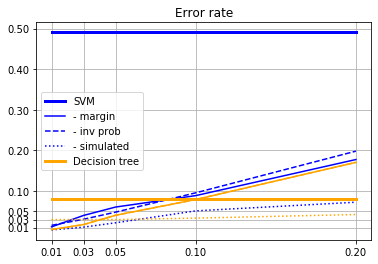

In [131]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

Text(0.5, 1.0, 'oneC')

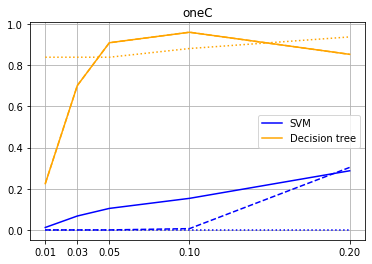

In [132]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

Text(0.5, 1.0, 'avgC')

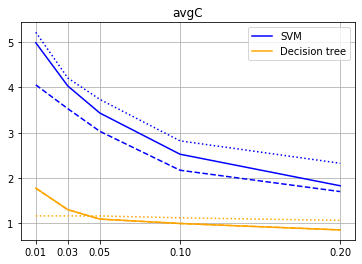

In [133]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

### Iris

In [134]:
data = load_iris();
data_df = pd.DataFrame(data['data'])
data_df.columns = data['feature_names']
data_df['target'] = data['target']
print(len(data_df))
data_df.head()

150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [135]:
data_df.groupby('target').count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,50,50,50,50
2,50,50,50,50


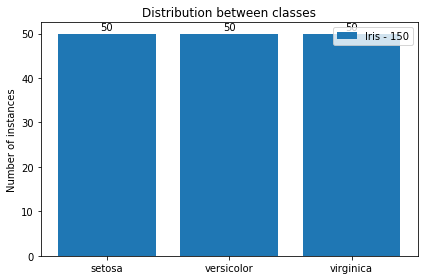

In [136]:
labels = data['target_names']
vals = [50, 50, 50]
x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, vals, width,   label='Iris - 150')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of instances')
ax.set_title('Distribution between classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)
#autolabel(rects2)
fig.tight_layout()
plt.show()

### Run conformal prediction

In [137]:
data = load_iris()

### svm

##### MarginErrFunc

In [138]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: ['setosa', 'versicolor', 'virginica']
size of the dataset: 150
train = 108, cal = 27, test = 15

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.04,0.000000,0.113333,2.420000,0.000000,0.013333,2.286667
0.03,5.5,0.04,0.020000,0.706667,1.306667,0.000000,0.466667,1.533333
0.05,5.5,0.04,0.073333,0.940000,0.953333,0.000000,0.673333,1.326667
0.10,5.5,0.04,0.113333,0.886667,0.886667,0.000000,0.800000,1.200000
0.20,5.5,0.04,0.186667,0.813333,0.813333,0.006667,0.906667,1.093333


#####  InverseProbabilityErrFunc

In [139]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['setosa', 'versicolor', 'virginica']
size of the dataset: 150
train = 108, cal = 27, test = 15
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.04,0.000000,0.113333,2.420000,0.000000,0.013333,2.286667
0.03,5.5,0.04,0.020000,0.706667,1.306667,0.000000,0.466667,1.533333
0.05,5.5,0.04,0.073333,0.940000,0.953333,0.000000,0.673333,1.326667
0.10,5.5,0.04,0.113333,0.886667,0.886667,0.000000,0.800000,1.200000
0.20,5.5,0.04,0.186667,0.813333,0.813333,0.006667,0.906667,1.093333


In [140]:
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.04,0.000000,0.113333,2.420000,0.000000,0.013333,2.286667,0.000000,0.113333,2.420000
0.03,5.5,0.04,0.020000,0.706667,1.306667,0.000000,0.466667,1.533333,0.020000,0.706667,1.306667
0.05,5.5,0.04,0.073333,0.940000,0.953333,0.000000,0.673333,1.326667,0.073333,0.940000,0.953333
0.10,5.5,0.04,0.113333,0.886667,0.886667,0.000000,0.800000,1.200000,0.113333,0.886667,0.886667
0.20,5.5,0.04,0.186667,0.813333,0.813333,0.006667,0.906667,1.093333,0.186667,0.813333,0.813333


<font color='red'>! Strange, no difference !</font>

### decision tree

##### MarginErrFunc

In [141]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

Info about dataset: 
classes: ['setosa', 'versicolor', 'virginica']
size of the dataset: 150
train = 108, cal = 27, test = 15

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.066667,0.000000,0.046667,2.733333,0.04,0.953333,1.046667
0.03,5.5,0.066667,0.033333,0.193333,2.113333,0.04,0.953333,1.046667
0.05,5.5,0.066667,0.073333,0.460000,1.580000,0.04,0.953333,1.046667
0.10,5.5,0.066667,0.140000,0.893333,0.893333,0.04,0.953333,1.046667
0.20,5.5,0.066667,0.173333,0.853333,0.853333,0.04,0.953333,1.046667


#####  InverseProbabilityErrFunc

In [142]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['setosa', 'versicolor', 'virginica']
size of the dataset: 150
train = 108, cal = 27, test = 15

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.066667,0.000000,0.046667,2.726667,0.04,0.953333,1.046667
0.03,5.5,0.066667,0.033333,0.193333,2.086667,0.04,0.953333,1.046667
0.05,5.5,0.066667,0.073333,0.473333,1.560000,0.04,0.953333,1.046667
0.10,5.5,0.066667,0.140000,0.893333,0.893333,0.04,0.953333,1.046667
0.20,5.5,0.066667,0.173333,0.853333,0.853333,0.04,0.953333,1.046667


In [143]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.066667,0.000000,0.046667,2.733333,0.04,0.953333,1.046667,0.000000,0.046667,2.726667
0.03,5.5,0.066667,0.033333,0.193333,2.113333,0.04,0.953333,1.046667,0.033333,0.193333,2.086667
0.05,5.5,0.066667,0.073333,0.460000,1.580000,0.04,0.953333,1.046667,0.073333,0.473333,1.560000
0.10,5.5,0.066667,0.140000,0.893333,0.893333,0.04,0.953333,1.046667,0.140000,0.893333,0.893333
0.20,5.5,0.066667,0.173333,0.853333,0.853333,0.04,0.953333,1.046667,0.173333,0.853333,0.853333


### Plot results: error rate

Text(0.5, 1.0, 'Error rate')

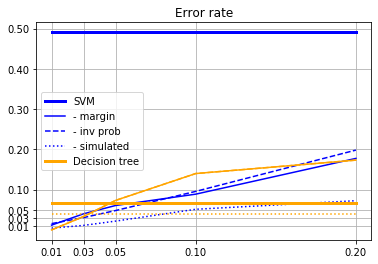

In [144]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

Text(0.5, 1.0, 'oneC')

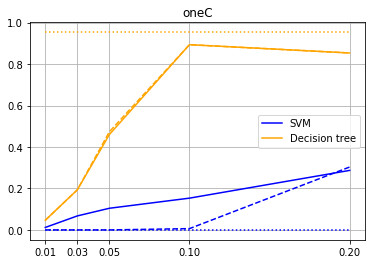

In [145]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

Text(0.5, 1.0, 'avgC')

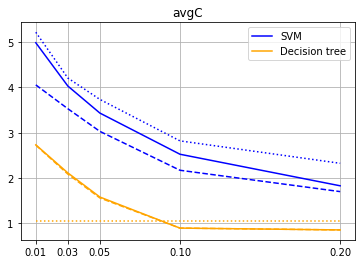

In [146]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

# ecoli dataset

In [202]:
def my_load_df(file_name, sep, class_idx=-1, cols_to_exclude=None, header=None):
    df = pd.read_csv(file_name,header=header, sep=sep )
    if cols_to_exclude != None:
        df = df.loc[~df[df.columns[class_idx]].isin(cols_to_exclude)].copy()
        pass
    #print(len(df))
    return df

In [203]:
from sklearn.preprocessing import LabelEncoder
def load_ecoli():
    print('Loading ecoli')
    # load ecoli dataset
    file = '../datasets/ecoli.csv'
    df = my_load_df('../datasets/ecoli.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=['imL', 'imS', 'omL'], header=None)
    df.drop(0, axis=1,inplace=True)
    print(df.dtypes)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values
    target_encoder = LabelEncoder()
    target = target_encoder.fit_transform(target) # convert cats to int 
    
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data


In [204]:
#ecoli_df = pd.read_csv('../datasets/ecoli.csv',header=None,sep=',')
ecoli_df = my_load_df('../datasets/ecoli.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=['imL', 'imS', 'omL'], header=None)
print(len(ecoli_df))
ecoli_df.drop(0, axis=1,inplace=True)


ecoli_df.head()

327


,1,2,3,4,5,6,7,8
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [150]:
data = load_ecoli()

Loading ecoli
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8     object
dtype: object


In [151]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)


<BarContainer object of 5 artists>

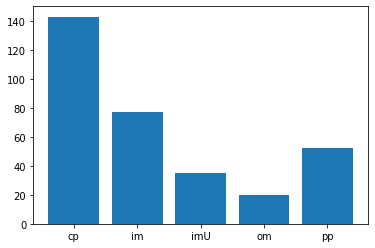

In [152]:
plotClasses(ecoli_df)  ## call this method on any data frame

### svm

##### MarginErrFunc

In [153]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()

Info about dataset: 
classes: ['cp', 'im', 'imU', 'om', 'pp']
size of the dataset: 327
train = 235, cal = 59, test = 33

average values for each eps


#####  InverseProbabilityErrFunc

In [154]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['cp', 'im', 'imU', 'om', 'pp']
size of the dataset: 327
train = 235, cal = 59, test = 33
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.114242,0.003030,0.000000,4.704545,0.000000,0.003030,3.716061
0.03,5.5,0.114242,0.006061,0.069697,4.016061,0.012727,0.164848,2.534242
0.05,5.5,0.114242,0.034242,0.580909,1.522727,0.018788,0.311515,2.063333
0.10,5.5,0.114242,0.089697,0.916970,1.083030,0.037879,0.483939,1.647273
0.20,5.5,0.114242,0.212424,0.856061,0.856061,0.050000,0.682121,1.339091


In [155]:
# <font color='red'>Inv_prob - avgC, margin - oneC</font>
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.114242,0.003030,0.006061,4.884545,0.000000,0.003030,3.716061,0.003030,0.000000,4.704545
0.03,5.5,0.114242,0.006061,0.075758,4.443939,0.012727,0.164848,2.534242,0.006061,0.069697,4.016061
0.05,5.5,0.114242,0.031818,0.621212,2.218788,0.018788,0.311515,2.063333,0.034242,0.580909,1.522727
0.10,5.5,0.114242,0.089697,0.907879,1.107576,0.037879,0.483939,1.647273,0.089697,0.916970,1.083030
0.20,5.5,0.114242,0.227576,0.822424,0.822424,0.050000,0.682121,1.339091,0.212424,0.856061,0.856061


<font color='red'>Inv_prob - avgC, margin - oneC</font>

### decision tree

##### MarginErrFunc

In [156]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

Info about dataset: 
classes: ['cp', 'im', 'imU', 'om', 'pp']
size of the dataset: 327
train = 235, cal = 59, test = 33

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.181515,0.012121,0.000000,4.665152,0.105152,0.780303,1.265455
0.03,5.5,0.181515,0.046667,0.006061,4.053030,0.105152,0.780303,1.265455
0.05,5.5,0.181515,0.056364,0.080303,3.343030,0.105152,0.780303,1.265455
0.10,5.5,0.181515,0.108182,0.680606,1.692727,0.108182,0.783333,1.262424
0.20,5.5,0.181515,0.211818,0.906061,0.945455,0.123636,0.846970,1.186364


#####  InverseProbabilityErrFunc

In [157]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['cp', 'im', 'imU', 'om', 'pp']
size of the dataset: 327
train = 235, cal = 59, test = 33

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.181515,0.012121,0.000000,4.686364,0.105152,0.780303,1.265455
0.03,5.5,0.181515,0.034242,0.000000,4.109394,0.105152,0.780303,1.265455
0.05,5.5,0.181515,0.052727,0.031212,3.448485,0.105152,0.780303,1.265455
0.10,5.5,0.181515,0.098788,0.459394,1.831212,0.108182,0.783333,1.262424
0.20,5.5,0.181515,0.214848,0.905758,0.942121,0.123636,0.846970,1.186364


In [158]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.181515,0.012121,0.000000,4.665152,0.105152,0.780303,1.265455,0.012121,0.000000,4.686364
0.03,5.5,0.181515,0.046667,0.006061,4.053030,0.105152,0.780303,1.265455,0.034242,0.000000,4.109394
0.05,5.5,0.181515,0.056364,0.080303,3.343030,0.105152,0.780303,1.265455,0.052727,0.031212,3.448485
0.10,5.5,0.181515,0.108182,0.680606,1.692727,0.108182,0.783333,1.262424,0.098788,0.459394,1.831212
0.20,5.5,0.181515,0.211818,0.906061,0.945455,0.123636,0.846970,1.186364,0.214848,0.905758,0.942121


### Plot results: error rate

Text(0.5, 1.0, 'Error rate')

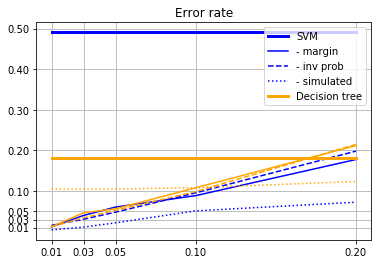

In [159]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

Text(0.5, 1.0, 'oneC')

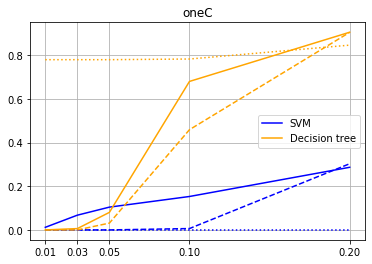

In [160]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

Text(0.5, 1.0, 'avgC')

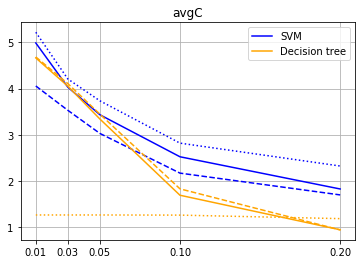

In [161]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

### zoo dataset

In [162]:
cols_to_exclude=[3, 4, 5, 6, 7]

In [163]:
 def load_zoo():
    print('Loading zoo')
    # load ecoli dataset
    file = '../datasets/zoo.csv'
    df = my_load_df('../datasets/zoo.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=cols_to_exclude, header=None)
    df.drop(0, axis=1,inplace=True)
    #print(df.dtypes)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    target = df[df.columns[-1]].values
    #print(target)
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data

In [164]:
#zoo_df = pd.read_csv('../datasets/zoo.csv',header=None,sep=',')
zoo_df = my_load_df('../datasets/zoo.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=cols_to_exclude, header=None)
print(len(zoo_df))
zoo_df.drop(0, axis=1,inplace=True)
zoo_df.head()

61


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1


In [165]:
data = load_zoo()

Loading zoo


In [166]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)


<BarContainer object of 2 artists>

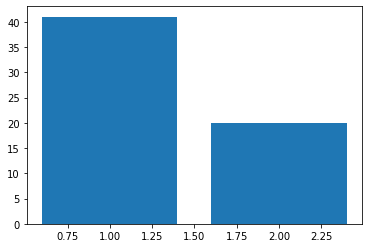

In [167]:
plotClasses(zoo_df)

### svm

##### MarginErrFunc

In [168]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: [1, 2]
size of the dataset: 61
train = 44, cal = 11, test = 6

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.0,0.000000,0.166667,1.833333,0.0,0.000000,2.000000
0.03,5.5,0.0,0.016667,0.400000,1.600000,0.0,0.650000,1.350000
0.05,5.5,0.0,0.016667,0.583333,1.383333,0.0,0.750000,1.250000
0.10,5.5,0.0,0.066667,0.933333,0.933333,0.0,0.983333,1.016667
0.20,5.5,0.0,0.216667,0.783333,0.783333,0.0,1.000000,1.000000


#####  InverseProbabilityErrFunc

In [169]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [1, 2]
size of the dataset: 61
train = 44, cal = 11, test = 6
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.0,0.000000,0.166667,1.833333,0.0,0.000000,2.000000
0.03,5.5,0.0,0.016667,0.400000,1.600000,0.0,0.650000,1.350000
0.05,5.5,0.0,0.016667,0.583333,1.383333,0.0,0.750000,1.250000
0.10,5.5,0.0,0.066667,0.933333,0.933333,0.0,0.983333,1.016667
0.20,5.5,0.0,0.216667,0.783333,0.783333,0.0,1.000000,1.000000


In [170]:
# <font color='red'>Inv_prob - avgC, margin - oneC</font>
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.0,0.000000,0.166667,1.833333,0.0,0.000000,2.000000,0.000000,0.166667,1.833333
0.03,5.5,0.0,0.016667,0.400000,1.600000,0.0,0.650000,1.350000,0.016667,0.400000,1.600000
0.05,5.5,0.0,0.016667,0.583333,1.383333,0.0,0.750000,1.250000,0.016667,0.583333,1.383333
0.10,5.5,0.0,0.066667,0.933333,0.933333,0.0,0.983333,1.016667,0.066667,0.933333,0.933333
0.20,5.5,0.0,0.216667,0.783333,0.783333,0.0,1.000000,1.000000,0.216667,0.783333,0.783333


### Plot results: error rate

Text(0.5, 1.0, 'Error rate')

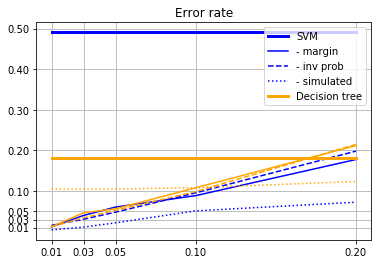

In [171]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

Text(0.5, 1.0, 'oneC')

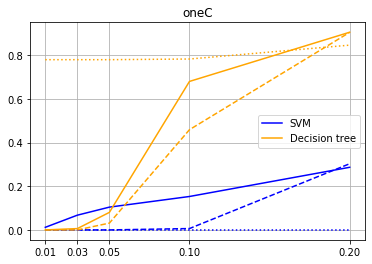

In [172]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

Text(0.5, 1.0, 'avgC')

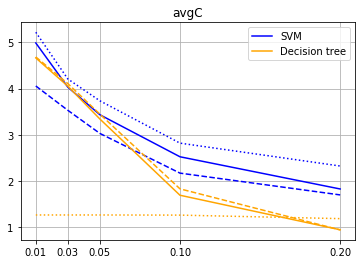

In [173]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## yeast dataset

In [174]:
# replace 4 spaces with two spaces in the file 
import fileinput

with fileinput.FileInput('../datasets/yeast_2.csv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("    ","  "),end='')

In [175]:
cols_to_exclude = ['ERL', 'POX', 'VAC']

In [223]:
def load_yeast_df(class_idx=-1, cols_to_exclude=None):
    df = pd.read_csv('../datasets/yeast_2.csv',header=None, delim_whitespace=True )
    if cols_to_exclude != None:
        df = df.loc[~df[df.columns[class_idx]].isin(cols_to_exclude)].copy()
        pass
    #print(len(df))
    return df

In [224]:
from sklearn.preprocessing import LabelEncoder
def load_yeast():
    print('Loading yeast')
    # load yeast dataset
    file = '../datasets/yeast_2.csv'
    df = load_yeast_df(class_idx=-1,cols_to_exclude=cols_to_exclude)
    df.drop(0, axis=1,inplace=True)
    print(df.dtypes)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values
    target_encoder = LabelEncoder()
    target = target_encoder.fit_transform(target) # convert cats to int 
    
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data


In [225]:
#yeast_df = pd.read_csv('../datasets/yeast_2.csv',header=None,sep=' ')
yeast_df = load_yeast_df(class_idx=-1,cols_to_exclude=cols_to_exclude)
print(len(yeast_df))
# yeast_df.drop(0, axis=1,inplace=True)
yeast_df.head()

1429


,0,1,2,3,4,5,6,7,8,9
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [226]:
yeast_df.groupby(yeast_df.columns[-1]).count()

,0,1,2,3,4,5,6,7,8
9,,,,,,,,,
CYT,463,463,463,463,463,463,463,463,463
EXC,35,35,35,35,35,35,35,35,35
ME1,44,44,44,44,44,44,44,44,44
ME2,51,51,51,51,51,51,51,51,51
ME3,163,163,163,163,163,163,163,163,163
MIT,244,244,244,244,244,244,244,244,244
NUC,429,429,429,429,429,429,429,429,429


In [227]:
data = load_yeast()

Loading yeast
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9     object
dtype: object


In [228]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

<BarContainer object of 7 artists>

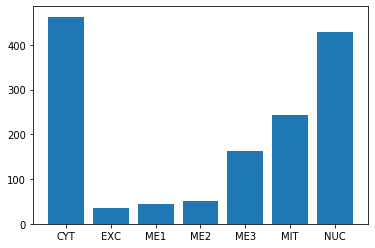

In [229]:
plotClasses(yeast_df)

In [230]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: ['CYT', 'EXC', 'ME1', 'ME2', 'ME3', 'MIT', 'NUC']
size of the dataset: 1429
train = 1029, cal = 257, test = 143

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.3863,0.011893,0.116153,6.035605,0.003497,0.000699,4.370309
0.03,5.5,0.3863,0.035009,0.184783,4.645711,0.009091,0.014685,3.555003
0.05,5.5,0.3863,0.065109,0.244982,3.393263,0.016099,0.027278,3.230242
0.10,5.5,0.3863,0.102881,0.310751,2.392032,0.044795,0.066478,2.620728
0.20,5.5,0.3863,0.207160,0.577356,1.599675,0.093795,0.143465,2.123161


In [231]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: ['CYT', 'EXC', 'ME1', 'ME2', 'ME3', 'MIT', 'NUC']
size of the dataset: 1429
train = 1029, cal = 257, test = 143
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.3863,0.009795,0.023087,3.565582,0.003497,0.000699,4.370309
0.03,5.5,0.3863,0.034290,0.089560,2.764222,0.009091,0.014685,3.555003
0.05,5.5,0.3863,0.051083,0.114070,2.491244,0.016099,0.027278,3.230242
0.10,5.5,0.3863,0.118989,0.226780,1.918768,0.044795,0.066478,2.620728
0.20,5.5,0.3863,0.200877,0.482902,1.522683,0.093795,0.143465,2.123161


In [232]:
# <font color='red'>Inv_prob - avgC, margin - oneC</font>
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.3863,0.011893,0.116153,6.035605,0.003497,0.000699,4.370309,0.009795,0.023087,3.565582
0.03,5.5,0.3863,0.035009,0.184783,4.645711,0.009091,0.014685,3.555003,0.034290,0.089560,2.764222
0.05,5.5,0.3863,0.065109,0.244982,3.393263,0.016099,0.027278,3.230242,0.051083,0.114070,2.491244
0.10,5.5,0.3863,0.102881,0.310751,2.392032,0.044795,0.066478,2.620728,0.118989,0.226780,1.918768
0.20,5.5,0.3863,0.207160,0.577356,1.599675,0.093795,0.143465,2.123161,0.200877,0.482902,1.522683


## balance data

In [182]:
from sklearn.preprocessing import LabelEncoder
def load_balance():
    print('Loading balance')
    # load balance dataset
    file = '../datasets/balance.csv'
    df = pd.read_csv(file,header=None, sep=',')
    df.drop(0, axis=1,inplace=True)
    print(df.dtypes)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values 
    
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data


In [183]:
balance_df = pd.read_csv('../datasets/balance.csv',header=None,sep=',')
print(len(balance_df))
# balance_df.drop(0, axis=1,inplace=True)
balance_df.head()

625


,0,1,2,3,4
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


In [184]:
data = load_balance()

Loading balance
1    int64
2    int64
3    int64
4    int64
dtype: object


In [185]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

<BarContainer object of 5 artists>

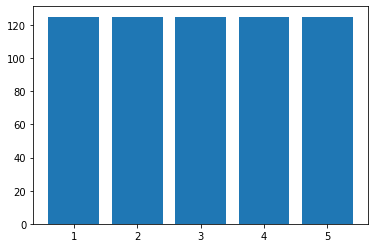

In [186]:
plotClasses(balance_df)

### svm

##### MarginErrFunc

In [187]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

Info about dataset: 
classes: [1, 2, 3, 4, 5]
size of the dataset: 625
train = 450, cal = 113, test = 62

average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.954839,0.008065,0.001613,4.854839,0.000000,0.0,5.000000
0.03,5.5,0.954839,0.025806,0.014516,4.708065,0.000000,0.0,5.000000
0.05,5.5,0.954839,0.053226,0.029032,4.462903,0.000000,0.0,5.000000
0.10,5.5,0.954839,0.101613,0.054839,3.991935,0.001613,0.0,4.664516
0.20,5.5,0.954839,0.225806,0.133871,3.138710,0.041935,0.0,3.945161


In [188]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

Info about dataset: 
classes: [1, 2, 3, 4, 5]
size of the dataset: 625
train = 450, cal = 113, test = 62
average values for each eps


,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC
eps,,,,,,,,
0.01,5.5,0.954839,0.017742,0.000000,4.845161,0.000000,0.0,5.000000
0.03,5.5,0.954839,0.030645,0.000000,4.482258,0.000000,0.0,5.000000
0.05,5.5,0.954839,0.046774,0.000000,4.224194,0.000000,0.0,5.000000
0.10,5.5,0.954839,0.108065,0.001613,3.637097,0.001613,0.0,4.664516
0.20,5.5,0.954839,0.222581,0.012903,2.945161,0.041935,0.0,3.945161


#####  InverseProbabilityErrFunc

In [189]:
# <font color='red'>Inv_prob - avgC, margin - oneC</font>
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

,fold,origin_err,Conf_err,Conf_oneC,Conf_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.954839,0.008065,0.001613,4.854839,0.000000,0.0,5.000000,0.017742,0.000000,4.845161
0.03,5.5,0.954839,0.025806,0.014516,4.708065,0.000000,0.0,5.000000,0.030645,0.000000,4.482258
0.05,5.5,0.954839,0.053226,0.029032,4.462903,0.000000,0.0,5.000000,0.046774,0.000000,4.224194
0.10,5.5,0.954839,0.101613,0.054839,3.991935,0.001613,0.0,4.664516,0.108065,0.001613,3.637097
0.20,5.5,0.954839,0.225806,0.133871,3.138710,0.041935,0.0,3.945161,0.222581,0.012903,2.945161


In [194]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC','inv_err', 'inv_oneC', 'inv_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

,fold,origin_err,marg_err,marg_oneC,marg_avgC,Simul_err,Simul_oneC,Simul_avgC,inv_err,inv_oneC,inv_avgC
eps,,,,,,,,,,,
0.01,5.5,0.490939,0.011887,0.011875,4.988801,0.004375,0.0,5.220770,0.017742,0.000000,4.845161
0.03,5.5,0.490939,0.040035,0.067531,4.032303,0.011254,0.0,4.209473,0.030645,0.000000,4.482258
0.05,5.5,0.490939,0.060668,0.104422,3.435122,0.021895,0.0,3.736745,0.046774,0.000000,4.224194
0.10,5.5,0.490939,0.088805,0.153223,2.525369,0.051285,0.0,2.820531,0.108065,0.001613,3.637097
0.20,5.5,0.490939,0.177614,0.287028,1.828086,0.072543,0.0,2.325228,0.222581,0.012903,2.945161


### decision treee

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## glass data

In [ ]:
cols_to_exclude = [3, 5, 6, 7]

In [ ]:
# from sklearn.preprocessing import LabelEncoder
def load_glass():
    print('Loading glass')
    # load glass dataset
    file = '../datasets/glass.csv'
    #df = pd.read_csv(file,header=None, sep=',')
    df = my_load_df('../datasets/glass.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=cols_to_exclude, header=None)
    df.drop(0, axis=1,inplace=True)
    print(df.dtypes)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values
    
    
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data
#load_glass()

In [ ]:
#glass_df = pd.read_csv('../datasets/glass.csv',header=None,sep=',')
glass_df = my_load_df('../datasets/glass.csv', sep=',', class_idx=-1, 
                      cols_to_exclude=cols_to_exclude, header=None)
print(len(glass_df))
glass_df.drop(0, axis=1,inplace=True)
glass_df.head()

In [ ]:
data = load_glass()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(glass_df)

### svm

###  MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
# <font color='red'>Inv_prob - avgC, margin - oneC</font>
tmp_df = res_df.groupby('eps').mean()
mean_df['inv_err'] = tmp_df['Conf_err']
mean_df['inv_oneC'] = tmp_df['Conf_oneC']
mean_df['inv_avgC'] = tmp_df['Conf_avgC']
mean_df

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

#### decision trre

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

### cars

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_cars():
    print('Loading cars')
    # load cars dataset
    file = '../datasets/cars.csv'
    df = pd.read_csv(file,header=None, sep=',')
#     df.drop(0, axis=0,inplace=True)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    data_points = df[df.columns[:-1]]
    target = df[df.columns[-1]].values 
    label_encoder = LabelEncoder()
   
    target = label_encoder.fit_transform(target)
    for i in range(6):
        data_points.iloc[:,i] = label_encoder.fit_transform(data_points.iloc[:,i])
    
#     data_points = data_points.apply(lambda x:label_encoder.fit_transform(x),axis=1)
  
    # scale target 
#     target -= min(target)
    data = {'target': target, 'data': data_points.values,
            'target_names': target_names}
    
    return data

In [ ]:
cars_df = pd.read_csv('../datasets/cars.csv',header=None,sep=',')
# print(len(cars_df))
# balance_df.drop(0, axis=0,inplace=True)
# print(len(cars_df))
cars_df.head()

In [ ]:
data = load_cars()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(cars_df)

#### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

### heat

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_heat():
    print('Loading heat')
    # load heat dataset
    file = '../datasets/heat.csv'
    df = pd.read_csv(file,header=0, sep=',')
    target_names = df.iloc[:,-1].unique()
    target_names.sort()
    label_encoder = LabelEncoder()
    data_points = df.iloc[:,2:-1] 
    target = df[df.columns[-1]].values 
    
    # scale target 
#     target -= min(target)
    data = {'target': target, 'data': data_points.values,
            'target_names': target_names}
    return data

In [ ]:
heat_df = pd.read_csv('../datasets/heat.csv',header=0,sep=',')
print(heat_df.shape)
# balance_df.drop(0, axis=1,inplace=True)
heat_df.head()
# heat_df.iloc[:,-1].unique()

In [ ]:
data = load_heat()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(heat_df)

### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## tai

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_tai():
    print('Loading tai')
    # load tai dataset
    file = '../datasets/tai.csv'
    df = pd.read_csv(file,header=0, sep=',')
#     df.drop(0, axis=1,inplace=True)
    target_names = df.iloc[:,1].unique()
    target_names.sort()
    
    target = df.iloc[:,1].values 
    label_encoder = LabelEncoder()
    target = label_encoder.fit_transform(target)
    # scale target 
#     target -= min(target)

    data = {'target': target, 'data': df.iloc[:,2:-1].values,
            'target_names': target_names}
    return data

In [ ]:
tai_df = pd.read_csv('../datasets/tai.csv',header=0,sep=',')
print(tai_df.shape)
# balance_df.drop(0, axis=1,inplace=True)
tai_df.head()
# tai_df.iloc[:,1].unique()

In [ ]:
data = load_tai()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(tai_df)

### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc


In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

### decision tree

### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True,
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
mean_df = res_df.groupby('eps').mean()
mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

#### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

#### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## vowel

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_vowel():
    print('Loading vowel')
    # load vowel dataset
    file = '../datasets/vowel.csv'
    df = pd.read_csv(file,header=None, sep=',')
    
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values 
    
    # scale target 
#     target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data
load_vowel()

In [ ]:
vowel_df = pd.read_csv('../datasets/vowel.csv',header=None,sep=',')
# print(len(vowel_df))
balance_df.dropna(axis=1,inplace=True)
vowel_df.head()

In [ ]:
data = load_vowel()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(vowel_df)

### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

#### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## wine

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_wine():
    print('Loading wine')
    # load wne dataset
    file = '../datasets/wine.csv'
    df = pd.read_csv(file,header=None, sep=',')
#     df.drop(0, axis=1,inplace=True)
    target_names = df.iloc[:,0].unique()
    target_names.sort()
    
    target = df.iloc[:,0].values 
    
    # scale target 
#     target -= min(target)
    data = {'target': target, 'data': df.iloc[:,1:-1].values,
            'target_names': target_names}
    return data

In [ ]:
wine_df = pd.read_csv('../datasets/wine.csv',header=None,sep=',')
# print(len(wine_df))
# balance_df.drop(0, axis=1,inplace=True)
wine_df.head()
wine_df.iloc[:,0].unique()

In [ ]:
data = load_wine()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.insert(0,"target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(wine_df)

#### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

#### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

#### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## steel

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_steel():
    print('Loading steel')
    # load steel dataset
    file = '../datasets/steel.csv'
    df = pd.read_csv(file,header=None, sep=',')
    df.drop(0, axis=1,inplace=True)
    target_names = df[df.columns[-1]].unique()
    target_names.sort()
    
    target = df[df.columns[-1]].values 
    
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df[df.columns[:-1]].values,
            'target_names': target_names}
    return data


In [ ]:
steel_df = pd.read_csv('../datasets/steel.csv',header=None,sep=',')
# print(len(steel_df))
# steel_df.drop(0, axis=1,inplace=True)
steel_df.head()

In [ ]:
data = load_steel()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(steel_df)

### Svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=svm_model_obj, 
                       params=svm_params,
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
svm_mean_df = res_df.groupby('eps').mean()
svm_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

#### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

#### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

#### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## user

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_user():
    print('Loading user')
    # load user dataset
    file = '../datasets/user.csv'
    df = pd.read_csv(file,header=0, sep=',')
    df.dropna( axis=1,inplace=True)
    target_names = df.iloc[:,-1].unique()
    target_names.sort()
    target = df.iloc[:,-1].values
    label_encoder = LabelEncoder()
    target = label_encoder.fit_transform(target)
    data_points = df.iloc[:,0:-1]
    # scale target 
#     target -= min(target)
    data = {'target': target, 'data':data_points.values,
            'target_names': target_names}
    return data


In [ ]:
user_df = pd.read_csv('../datasets/user.csv',header=0,sep=',')
print(len(user_df))
user_df.dropna( axis=1,inplace=True)
print(len(user_df))
user_df.head()

In [ ]:
data = load_user()

In [ ]:
def plotClasses(df):
    
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(user_df)

#### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=svm_model_obj, 
                       params=svm_params,
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
svm_mean_df = res_df.groupby('eps').mean()
svm_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
dt_mean_df = res_df.groupby('eps').mean()
dt_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

#### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')

## wave

In [ ]:
from sklearn.preprocessing import LabelEncoder
def load_wave():
    print('Loading wave')
    # load wave dataset
    file = '../datasets/wave.csv'
    df = pd.read_csv(file,header=None, sep=',')
    df.drop(0, axis=1,inplace=True)
    target_names = df.iloc[:,-1].unique()
    target_names.sort()
    target = df.iloc[:,-1].values 
    # scale target 
    target -= min(target)
    data = {'target': target, 'data': df.iloc[:,0:-1].values,
            'target_names': target_names}
    return data

In [ ]:
wave_df = pd.read_csv('../datasets/wave.csv',header=None,sep=',')
# print(len(wave_df))
# wave_df.dropna( axis=0,inplace=True)
# print(len(wave_df))

wave_df.head()

In [ ]:
data = load_wave()

In [ ]:
def plotClasses(df):
    cols = ["col"+str(x) for x in range(1,len(df.columns))]
    cols.append("target")
    df.columns = cols # add column names to the data frame 
    counts = df.groupby(by="target").count()[['col1']]
    labels = counts.index.to_list()
    data_points = counts.values.reshape(len(counts),)
    return plt.bar(labels,data_points)

In [ ]:
plotClasses(wave_df)

#### svm

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=svm_model_obj, 
                       params=svm_params,
                       epsilon_arr=eps_err, err_func=MarginErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
svm_mean_df = res_df.groupby('eps').mean()
svm_mean_df

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True,
                             seed=1, verbose=True)
# Get average values of metrics
print('average values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
svm_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
svm_mean_df['inv_err'] = tmp_df['Conf_err']
svm_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
svm_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
svm_mean_df

##### decision tree

##### MarginErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

#####  InverseProbabilityErrFunc

In [ ]:
res_df = run_conformal(data, model_obj=dt_model_obj, 
                       params={MIN_SAMPLES_KEY: max(5, int(dt_min_sample_ratio * len(data['data'])))},
                       epsilon_arr=eps_err, err_func=InverseProbabilityErrFunc, smoothing=True, 
                       seed=1, verbose=True)
# Get average values of metrics
print('\naverage values for each eps')
res_df.groupby('eps').mean()

In [ ]:
tmp_df = res_df.groupby('eps').mean()
# rename columns for margin function
dt_mean_df.columns = ['fold', 'origin_err', 'marg_err', 'marg_oneC', 'marg_avgC', 
                       'Simul_err', 'Simul_oneC', 'Simul_avgC']
# these columns contain results for inverse probability non-conformity function
dt_mean_df['inv_err'] = tmp_df['Conf_err']
dt_mean_df['inv_oneC'] = tmp_df['Conf_oneC']
dt_mean_df['inv_avgC'] = tmp_df['Conf_avgC']
dt_mean_df

### Plot results: error rate

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['origin_err'], label='SVM', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='- margin', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='- inv prob', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='- simulated', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['origin_err'], label='Decision tree', color=color, lw=3) # thik line for original error
plt.plot(eps_err, df['marg_err'], label='_nolegend_', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_err'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_err'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
y_ticks = eps_err[:]
y_ticks.extend([0.3, 0.4, 0.5])
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.title('Error rate')

#### Plot: oneC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_oneC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_oneC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_oneC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_oneC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('oneC')

#### avgC

In [ ]:
# SVM color - blue
color = 'blue'
df = svm_mean_df
plt.plot(eps_err, df['marg_avgC'], label='SVM', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

# Decision tree color - orange
color = 'orange'
df = dt_mean_df
plt.plot(eps_err, df['marg_avgC'], label='Decision tree', color=color, ) # normal line for margin error
plt.plot(eps_err, df['inv_avgC'], label='_nolegend_', color=color, linestyle='--') # dashed line for inv_prob error
plt.plot(eps_err, df['Simul_avgC'], label='_nolegend_', color=color, linestyle=':') # dotted line for simulation error

plt.xticks(eps_err)
plt.grid(True)
plt.legend()
plt.title('avgC')